In [1]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModel
from PIL import Image

In [2]:
image_folder = Path('/home/nas/datasets/publique/VisA_anomaly_detection_dataset/pcb3/Data/Images')

normal_image_path = image_folder / 'Normal'
anomaly_image_path = image_folder / 'Anomaly'

normal_image_paths = list(normal_image_path.glob('*'))
anomaly_image_paths = list(anomaly_image_path.glob('*'))

In [3]:
normal_image_paths[0].parts[-2]

'Normal'

In [4]:
import random

def plot_image_grid(image_paths):
    fig, axs = plt.subplots(2, 5, figsize=(35, 10))
    for i, ax in enumerate(axs.flatten()):
        image_path = image_paths[random.choice(np.arange(len(image_paths)))]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
    plt.show()

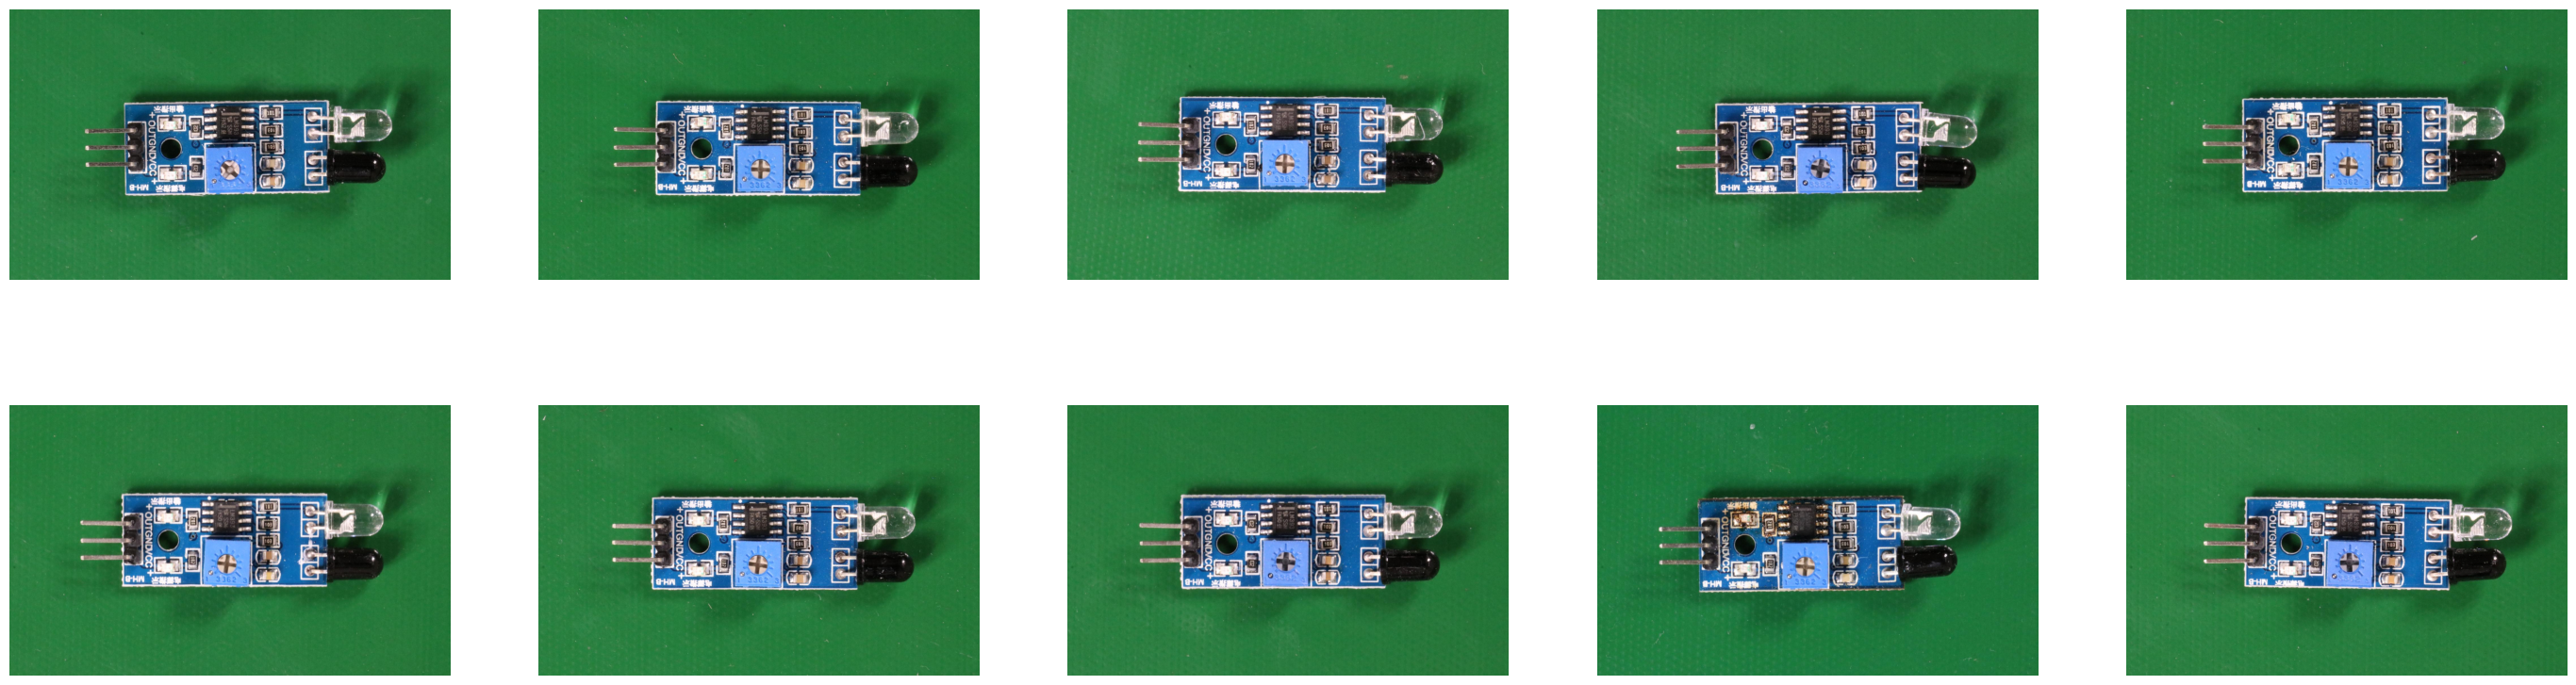

In [5]:
plot_image_grid(normal_image_paths)

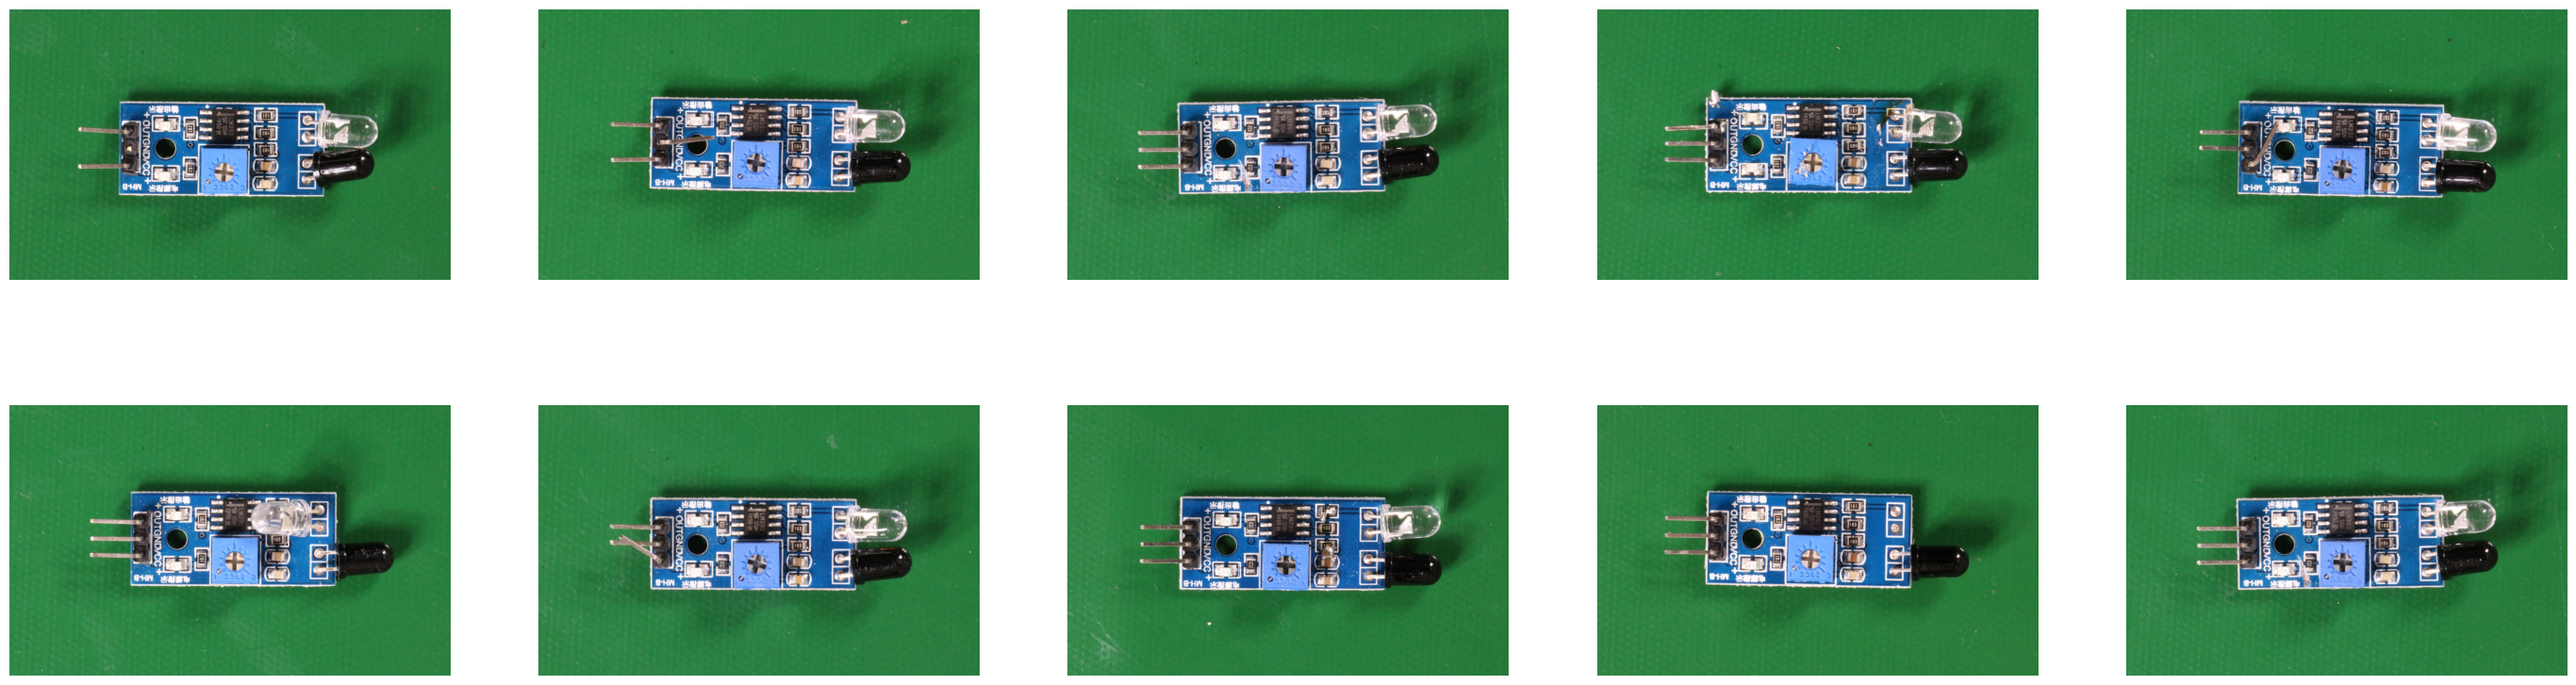

In [6]:
plot_image_grid(anomaly_image_paths)

In [7]:
processor = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        """This class extracts the feature maps from a pretrained Resnet model."""
        super(resnet_feature_extractor, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False

        

        # Hook to extract feature maps
        def hook(module, input, output) -> None:
            """This hook saves the extracted feature map on self.featured."""
            self.features.append(output)

        self.model.layer2[-1].register_forward_hook(hook)  

    def forward(self, input):

        self.features = []
        with torch.no_grad():
            _ = self.model(input)

        self.avg = torch.nn.AvgPool2d(3, stride=1)
        self.fmap_size = self.features[0].shape[-2]         # Feature map sizes h, w
      
        patch = torch.cat([self.avg(fmap) for fmap in self.features],1)

        return patch

In [9]:
teacher = resnet_feature_extractor().cuda()

In [10]:
with torch.no_grad():
    image_tensor = processor(Image.open(normal_image_paths[0])).unsqueeze(0).to(device)
    output = teacher(image_tensor)

In [11]:
output.shape

torch.Size([1, 512, 30, 30])

In [12]:
def get_pdn_small(out_channels=512, padding=False):
    pad_mult = 1 if padding else 0
    return nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4,
                  padding=3 * pad_mult),
        nn.ReLU(inplace=True),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=1 * pad_mult),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4,
                  padding=3 * pad_mult),
        nn.ReLU(inplace=True),
        nn.AvgPool2d(kernel_size=2, stride=2, padding=1 * pad_mult),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3,
                  padding=1 * pad_mult),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=256, out_channels=out_channels, kernel_size=4),
        nn.AdaptiveAvgPool2d((30,30))
    )

In [13]:
student = get_pdn_small().cuda()

In [14]:
with torch.no_grad():
    image_tensor = processor(Image.open(normal_image_paths[0])).unsqueeze(0).to(device)
    output = student(image_tensor)
    
output.shape

torch.Size([1, 512, 30, 30])

In [15]:
class VisADataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path=self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = torch.tensor(0, dtype=torch.long) if image_path.parts[-2] == 'Normal' else torch.tensor(1, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label
    
normal_dataset = VisADataset(normal_image_paths, transform=processor)
anomaly_dataset = VisADataset(anomaly_image_paths, transform=processor)

normal_dataloader = DataLoader(normal_dataset, batch_size=4, shuffle=True,)
anomaly_dataloader = DataLoader(anomaly_dataset, batch_size=4, shuffle=False)

In [17]:

from torch.optim import AdamW
from tqdm.auto import tqdm

teacher = teacher.to(device).eval()  # freeze later
student = student.to(device).train()

# 2. Freeze teacher
for param in teacher.parameters():
    param.requires_grad = False

# 3. Loss and Optimizer
criterion = nn.MSELoss()
optimizer = AdamW(student.parameters(), lr=1e-4, weight_decay=1e-5)

# 4. Training Loop
num_epochs = 20

for epoch in range(num_epochs):
    student.train()
    running_loss = 0.0

    for images, _ in tqdm(normal_dataloader,total=len(normal_dataloader)):  # Labels are unused
        images = images.to(device)

        with torch.no_grad():
            teacher_features = teacher(images)

        student_features = student(images)

        loss = criterion(student_features, teacher_features)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(normal_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.6f}")

  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [1/20] - Loss: 0.270304


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [2/20] - Loss: 0.141005


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [3/20] - Loss: 0.120027


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [4/20] - Loss: 0.109045


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [5/20] - Loss: 0.102121


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [6/20] - Loss: 0.097171


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [7/20] - Loss: 0.093276


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [8/20] - Loss: 0.090206


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [9/20] - Loss: 0.087788


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [10/20] - Loss: 0.085846


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [11/20] - Loss: 0.084324


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [12/20] - Loss: 0.082921


  0%|          | 0/252 [00:00<?, ?it/s]

Epoch [13/20] - Loss: 0.081791


  0%|          | 0/252 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
torch.save(student.state_dict(), 'student.pth')

# Evaluation

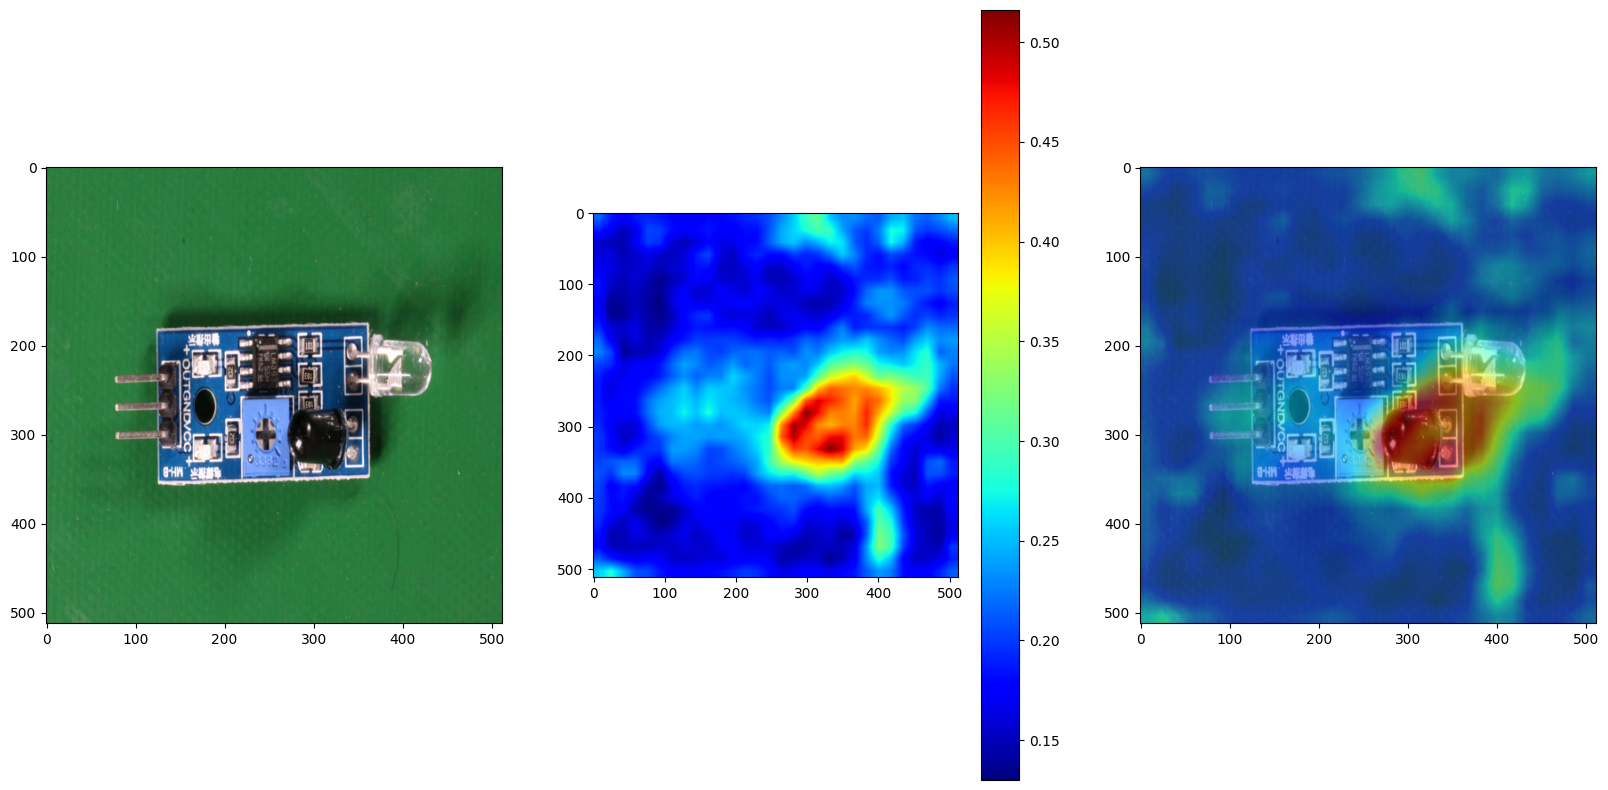

In [43]:
import torch.nn.functional as F
idx=6
image = Image.open(anomaly_image_paths[idx]).convert('RGB').resize((512,512))
image_size = image.size

student.eval()
with torch.no_grad():
    nok_image = processor(image).unsqueeze(0).to(device)
    st_output = student(nok_image)
    te_output = teacher(nok_image)

anomaly_map = torch.abs(st_output - te_output).mean(dim=1)
anomaly_map = F.interpolate(anomaly_map.unsqueeze(0), size=image_size, mode='bilinear', align_corners=False).squeeze()


plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(image, cmap='jet')
plt.subplot(1,3,2)
plt.imshow(anomaly_map.cpu().numpy(), cmap='jet')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(image, cmap='jet')
plt.imshow(anomaly_map.cpu().numpy(), cmap='jet',alpha=0.5)
plt.show()

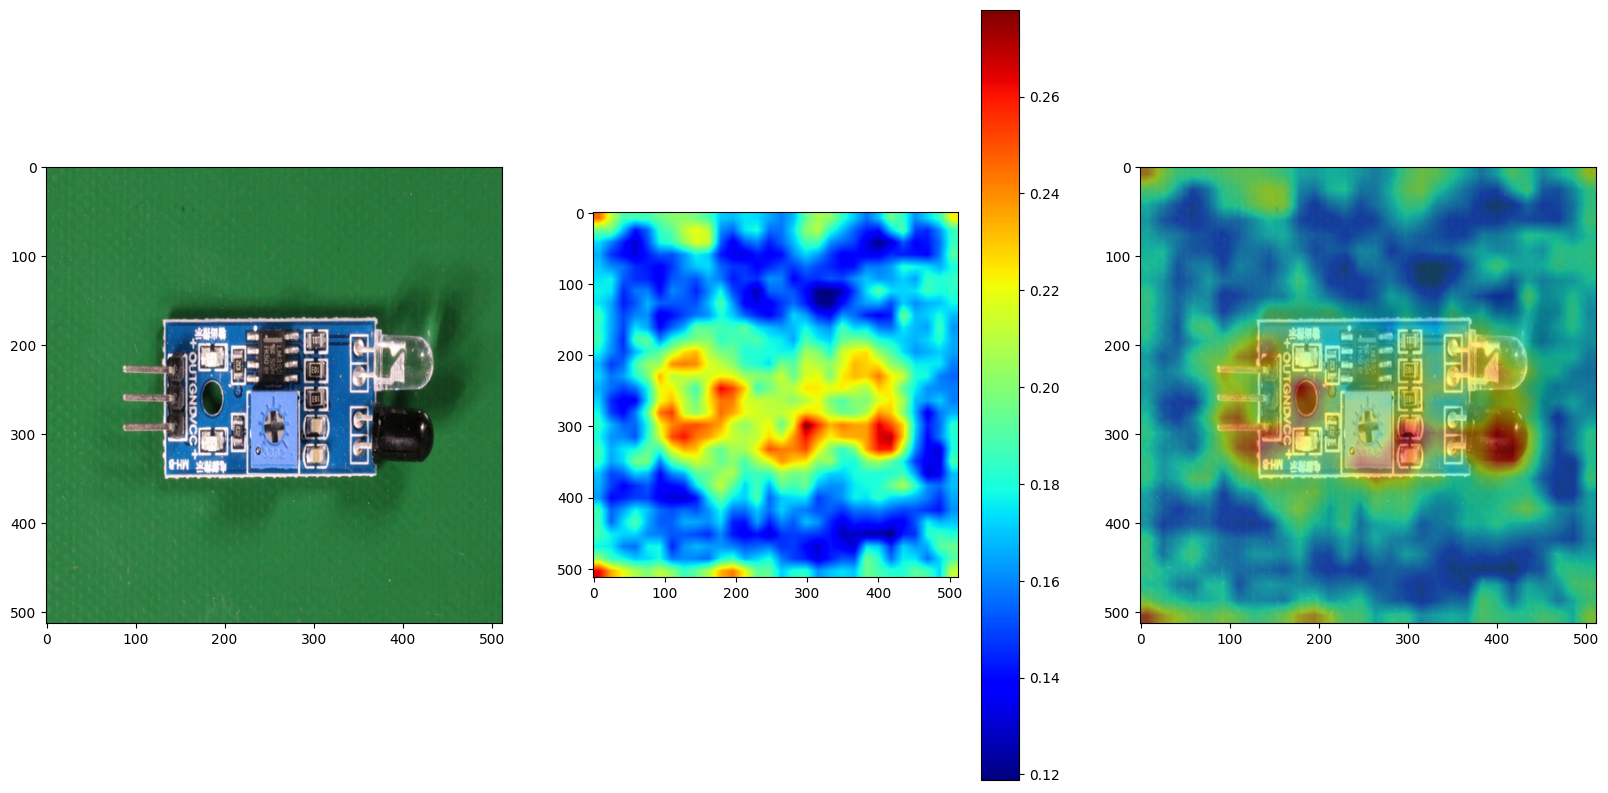

In [44]:
import torch.nn.functional as F
idx=6
image = Image.open(normal_image_paths[idx]).convert('RGB').resize((512,512))
image_size = image.size

student.eval()
with torch.no_grad():
    nok_image = processor(image).unsqueeze(0).to(device)
    st_output = student(nok_image)
    te_output = teacher(nok_image)

anomaly_map = torch.abs(st_output - te_output).mean(dim=1)
anomaly_map = F.interpolate(anomaly_map.unsqueeze(0), size=image_size, mode='bilinear', align_corners=False).squeeze()


plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(image, cmap='jet')
plt.subplot(1,3,2)
plt.imshow(anomaly_map.cpu().numpy(), cmap='jet')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(image, cmap='jet')
plt.imshow(anomaly_map.cpu().numpy(), cmap='jet',alpha=0.5)
plt.show()

In [106]:
def predict(image_tensor,image_size):
    student.eval()
    with torch.no_grad():
        nok_image = image_tensor
        st_output = student(nok_image)
        te_output = teacher(nok_image)

    anomaly_map = torch.abs(st_output - te_output).mean(dim=1)
    
    flat = anomaly_map.view(-1)
    threshold = torch.quantile(flat, 0.95)
    top_1_percent = flat[flat >= threshold]
    anomaly_score = top_1_percent.mean()
    # anomaly_score = torch.max(anomaly_map)
    
    anomaly_map = F.interpolate(anomaly_map.unsqueeze(0), size=image_size, mode='bilinear', align_corners=False).squeeze()

    return anomaly_map.cpu().numpy(),anomaly_score.cpu().numpy()

In [107]:
y_score_normal = []

counter=0
for image_tensor,label in tqdm(normal_dataset,total=len(normal_dataset)):
    counter = counter+1
    _,score = predict(image_tensor.unsqueeze(0).to(device),(image_tensor.shape[-2],image_tensor.shape[-1]))
    y_score_normal.append(score)
    if counter>100:
        break
    
threshold = np.quantile(y_score_normal, 0.95)
    

  0%|          | 0/1006 [00:00<?, ?it/s]

In [108]:
y_score_anomaly = []

for image_tensor,label in tqdm(anomaly_dataset,total=len(anomaly_dataset)):
    _,score = predict(image_tensor.unsqueeze(0).to(device),(image_tensor.shape[-2],image_tensor.shape[-1]))
    y_score_anomaly.append(score)

  0%|          | 0/100 [00:00<?, ?it/s]

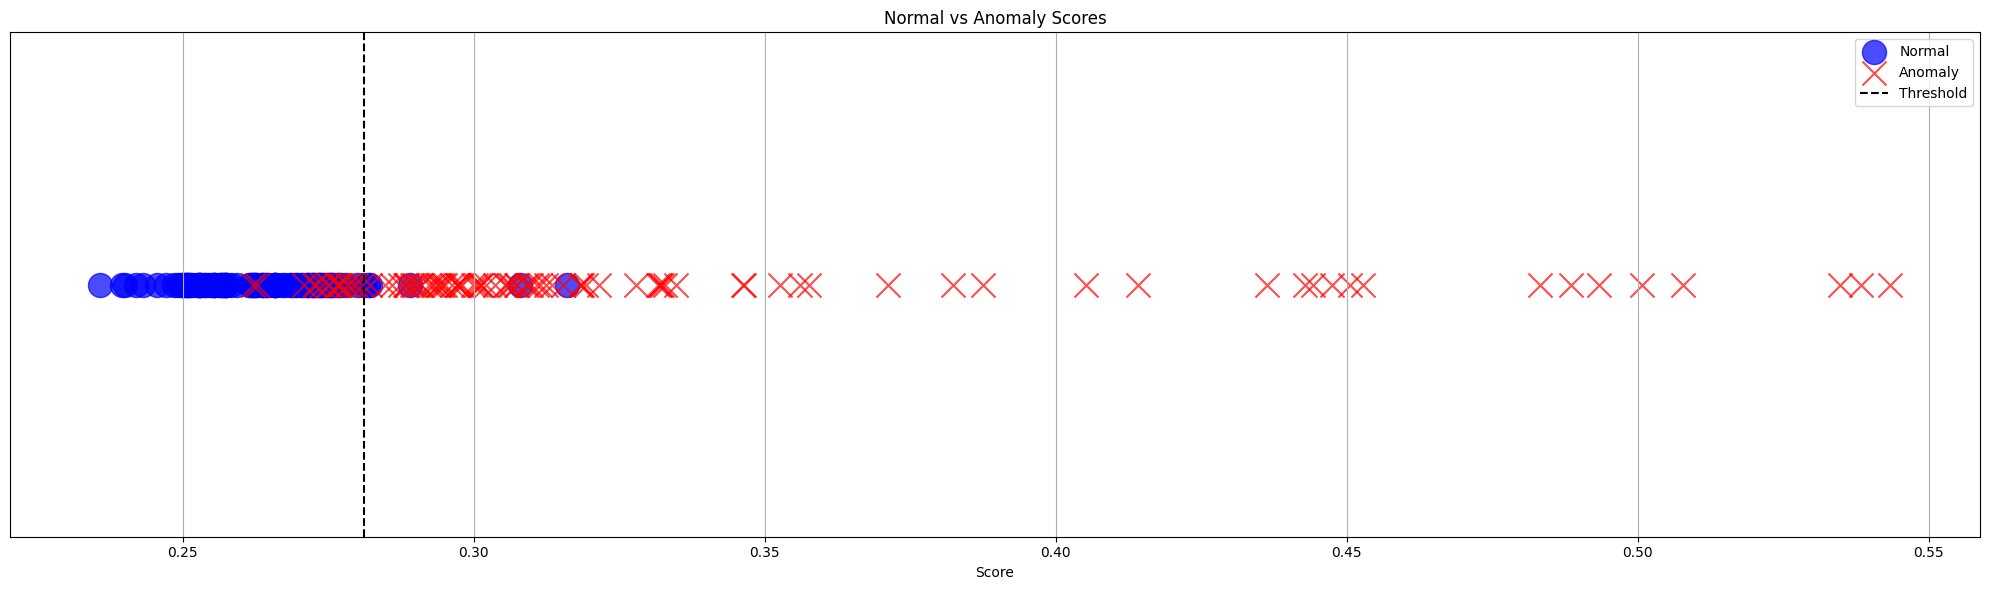

In [109]:
all_scores = y_score_normal + y_score_anomaly
all_labels = [0]*len(y_score_normal) + [1]*len(y_score_anomaly)

# Convert to NumPy arrays for easy indexing
all_scores = np.array(all_scores)
all_labels = np.array(all_labels)

plt.figure(figsize=(20, 6))
# Plot normal (label=0) as blue dots
plt.scatter(all_scores[all_labels == 0], 
            np.zeros_like(all_scores[all_labels == 0]), 
            color='blue', marker='o', label='Normal', s=300,alpha=0.7)

# Plot anomaly (label=1) as red crosses
plt.scatter(all_scores[all_labels == 1], 
            np.zeros_like(all_scores[all_labels == 1]), 
            color='red', marker='x', label='Anomaly', s=300,alpha=0.7)

plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel('Score')
plt.yticks([])  # Hide y-axis ticks
plt.legend()
plt.title("Normal vs Anomaly Scores")
plt.grid(True)
plt.tight_layout()
plt.show()

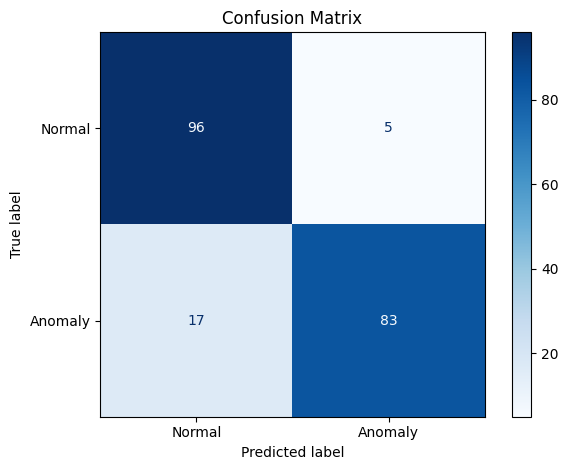

F1 Score     : 0.8830


In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

# Predicted and true labels
predicted_labels = [1 if s > threshold else 0 for s in all_scores]  # 1 = anomaly
true_labels = all_labels  # Assuming 0 = normal, 1 = anomaly

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()



# Compute F1 score
f1 = f1_score(true_labels, predicted_labels)
print(f"F1 Score     : {f1:.4f}")